In [1]:
%matplotlib inline
import os
import sys
sys.path.append('..')
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu

# flag to decide if run everything or just visualize results
run_all_flag = False

In [2]:
import freyberg_setup
if run_all_flag:
    freyberg_setup.setup_pest_kr()
working_dir = freyberg_setup.WORKING_DIR_KR
pst_name = freyberg_setup.PST_NAME_KR

## First read in the PST file and find what are the starting values for K and R

In [3]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))
inpst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
parnme,,,,,,,,,,
rch_0,rch_0,log,factor,0.8,0.75,1.25,rch,1.0,0.0,1
rch_1,rch_1,fixed,factor,1.0,0.75,1.25,rch,1.0,0.0,1
hk,hk,log,factor,12.0,3.00,12.00,hk,1.0,0.0,1


In [4]:
inpst.parameter_data.loc['rch_1','partrans']= 'fixed'
inpst.observation_data.loc[inpst.observation_data.obgnme=='calflux','weight']=0.0
inpst.control_data.noptmax=0
inpst.write(os.path.join(working_dir,pst_name))

In [5]:
os.chdir(working_dir)
pyemu.helpers.run('pestpp {0}'.format(pst_name))
os.chdir('..')

run():./pestpp freyberg_kr.pst


In [6]:
inpst.phi_components

{'calflux': 0.0,
 'calhead': 2105.7758714352635,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_river_l': 0.0,
 'flx_storage': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'foreflux': 0.0,
 'forehead': 0.0,
 'foretrav': 0.0,
 'head': 0.0,
 'pothead': 0.0,
 'vol_constan': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_river_l': 0.0,
 'vol_storage': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

## We can import a function to explore a range of K and R values to make a response surface

In [7]:
import freyberg_response_surface as resurf

## First we should write out the control file with new bounds to bracket where values will be explored

## `rch_0` already spans the bounds we want, but `hk` is too wide

In [8]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))
par = inpst.parameter_data

par.loc['hk', 'parlbnd'] = 3
par.loc['hk', 'parubnd'] = 12

inpst.write(os.path.join(working_dir,pst_name))

## Run the `run_respsurf` function to calculate the response surface

In [9]:
if run_all_flag:
    resurf.run_respsurf(par_names=['hk','rch_0'], pstfile=pst_name)

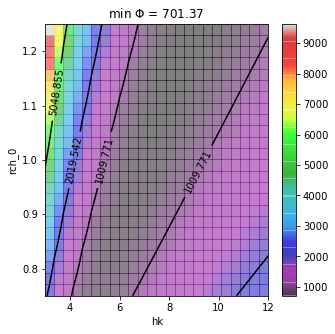

In [10]:
resurf.plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name);

In [11]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))
inpst.parameter_data.loc['hk', 'parval1'] = 12
inpst.parameter_data.loc['rch_0', 'parval1'] = 0.8

inpst.control_data.noptmax =  -1
inpst.write(os.path.join(working_dir,pst_name))

In [12]:
if run_all_flag:
    os.chdir(working_dir)
    pyemu.helpers.run('pestpp {0}'.format(pst_name))
    os.chdir('..')

### Now let's run PEST++ and see what we get for an estimate of the parameters
 * set NOPTMAX=-1
 * run PEST++

In [13]:
pars = pd.read_csv(os.path.join(working_dir,pst_name.replace('.pst','.ipar')))
pars

,iteration,rch_0,rch_1,hk
0,0,0.8,1,12


In [14]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace('.pst','.jcb')))
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

,rch_0,hk
rch_0,8258.693688,-7221.924547
hk,-7221.924547,6412.128032


In [15]:
sc.jco.to_dataframe().loc[inpst.nnz_obs_names]

,rch_0,hk
cr03c16_19700102,0.886282,-0.600416
cr03c10_19700102,4.067717,-3.766799
cr04c9_19700102,4.873227,-4.500495
cr10c2_19700102,12.275978,-11.781516
cr14c11_19700102,1.865253,-1.207386
cr16c17_19700102,1.151990,-0.965734
cr22c11_19700102,2.721080,-1.950695
cr23c16_19700102,0.913427,-0.835731
cr25c5_19700102,8.089972,-6.679732
cr27c7_19700102,6.398180,-4.878923


In [16]:
R = covar.to_pearson()
R.df()

,rch_0,hk
rch_0,1.000000,-0.992422
hk,-0.992422,1.000000


# What if we also have a calibration flux observation?

We can set this up by simply assigning non-zero weight to the observation in the group called `calflux`

We'll read in the PST file, change just that one value and write out a new PST file.

In [17]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))

In [18]:
inpst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
parnme,,,,,,,,,,
rch_0,rch_0,log,factor,0.8,0.75,1.25,rch,1.0,0.0,1
rch_1,rch_1,fixed,factor,1.0,0.75,1.25,rch,1.0,0.0,1
hk,hk,log,factor,12.0,3.00,12.00,hk,1.0,0.0,1


In [19]:
inpst.parameter_data.loc['rch_1','partrans']= 'fixed'
inpst.observation_data.loc[inpst.observation_data.obgnme=='calflux','weight']=10
inpst.control_data.noptmax=0
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.r1.pst')))

In [20]:
if run_all_flag:
    os.chdir(working_dir)
    pyemu.helpers.run('pestpp {0}'.format(pst_name.replace('.pst','.r1.pst')))
    os.chdir('..')

In [21]:
inpst.phi_components

{'calflux': 71836202.2556554,
 'calhead': 2105.7758714352635,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_river_l': 0.0,
 'flx_storage': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'foreflux': 0.0,
 'forehead': 0.0,
 'foretrav': 0.0,
 'head': 0.0,
 'pothead': 0.0,
 'vol_constan': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_river_l': 0.0,
 'vol_storage': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

In [22]:
if run_all_flag:
    resurf.run_respsurf(par_names=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r1.pst'))

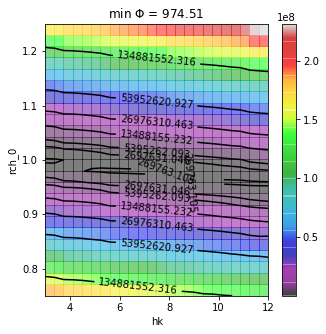

In [23]:
resurf.plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r1.pst'));

In [24]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name.replace('.pst','.r1.pst')))
inpst.parameter_data.loc['hk', 'parval1'] = 12
inpst.parameter_data.loc['rch_0', 'parval1'] = 0.8

inpst.control_data.noptmax =  -1
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.r1.pst')))

In [25]:
if run_all_flag:
    os.chdir(working_dir)
    pyemu.helpers.run('pestpp {0}'.format(pst_name.replace('.pst','.r1.pst')))
    os.chdir('..')

### We can look at the correlation again

In [26]:
pars = pd.read_csv(os.path.join(working_dir,pst_name.replace('.pst','.r1.ipar')))
pars

,iteration,rch_0,rch_1,hk
0,0,0.8,1,12


In [27]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace('.pst','.r1.jcb')))
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

,rch_0,hk
rch_0,1.038275e+10,7.269547e+08
hk,7.269547e+08,5.090565e+07


In [28]:
R = covar.to_pearson()
R.df()

,rch_0,hk
rch_0,1.000000,0.999927
hk,0.999927,1.000000


In [29]:
sc.jco.to_dataframe().loc[inpst.nnz_obs_names]

,rch_0,hk
flx_river_l_19700102,-10189.574242,-713.437000
cr03c16_19700102,0.886282,-0.600416
cr03c10_19700102,4.067717,-3.766799
cr04c9_19700102,4.873227,-4.500495
cr10c2_19700102,12.275978,-11.781516
cr14c11_19700102,1.865253,-1.207386
cr16c17_19700102,1.151990,-0.965734
cr22c11_19700102,2.721080,-1.950695
cr23c16_19700102,0.913427,-0.835731
cr25c5_19700102,8.089972,-6.679732


## OK - that was bonkers. Maybe a little less weight?

In [30]:
inpst.parameter_data.loc['rch_1','partrans']= 'fixed'
inpst.observation_data.loc[inpst.observation_data.obgnme=='calflux','weight']=0.001
inpst.control_data.noptmax=0
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.r2.pst')))

In [31]:
os.chdir(working_dir)
pyemu.helpers.run('pestpp {0}'.format(pst_name.replace('.pst','.r2.pst')))
os.chdir('..')

run():./pestpp freyberg_kr.r2.pst


In [32]:
inpst.phi_components

{'calflux': 0.7183620225565539,
 'calhead': 2105.7758714352635,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_river_l': 0.0,
 'flx_storage': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'foreflux': 0.0,
 'forehead': 0.0,
 'foretrav': 0.0,
 'head': 0.0,
 'pothead': 0.0,
 'vol_constan': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_river_l': 0.0,
 'vol_storage': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

In [33]:
if run_all_flag:
    resurf.run_respsurf(par_names=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r2.pst'))

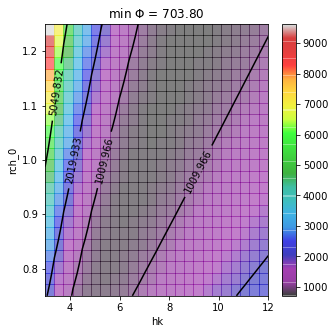

In [34]:
resurf.plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r2.pst'));

In [35]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name.replace('.pst','.r2.pst')))
inpst.parameter_data.loc['hk', 'parval1'] = 12
inpst.parameter_data.loc['rch_0', 'parval1'] = 0.8

inpst.control_data.noptmax =  -1
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.r2.pst')))

In [36]:
if run_all_flag:
    os.chdir(working_dir)
    pyemu.helpers.run('pestpp {0}'.format(pst_name.replace('.pst','.r2.pst')))
    os.chdir('..')

## Let's check out correlation again

In [37]:
pars = pd.read_csv(os.path.join(working_dir,pst_name.replace('.pst','.r2.ipar')))
pars

,iteration,rch_0,rch_1,hk
0,0,0.8,1,12


In [38]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace('.pst','.r2.jcb')))
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

,rch_0,hk
rch_0,8362.521111,-7214.654928
hk,-7214.654928,6412.637024


In [39]:
R = covar.to_pearson()
R.df()

,rch_0,hk
rch_0,1.00000,-0.98521
hk,-0.98521,1.00000


## Can we find a happy medium? Perhaps if we balance the components of the objective function

In [40]:
inpst.parameter_data.loc['rch_1','partrans']= 'fixed'
inpst.observation_data.loc[inpst.observation_data.obgnme=='calflux','weight']=0.05
inpst.control_data.noptmax=0
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.r3.pst')))

In [41]:
os.chdir(working_dir)
pyemu.helpers.run('pestpp {0}'.format(pst_name.replace('.pst','.r3.pst')))
os.chdir('..')

run():./pestpp freyberg_kr.r3.pst


In [42]:
inpst.phi_components

{'calflux': 1795.9050563913854,
 'calhead': 2105.7758714352635,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_river_l': 0.0,
 'flx_storage': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'foreflux': 0.0,
 'forehead': 0.0,
 'foretrav': 0.0,
 'head': 0.0,
 'pothead': 0.0,
 'vol_constan': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_river_l': 0.0,
 'vol_storage': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

In [43]:
if run_all_flag:
    resurf.run_respsurf(par_names=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r3.pst'))

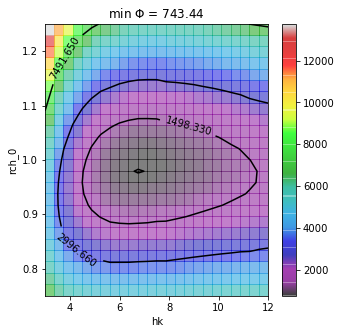

In [44]:
resurf.plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r3.pst'));

In [45]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name.replace('.pst','.r3.pst')))
inpst.parameter_data.loc['hk', 'parval1'] = 12
inpst.parameter_data.loc['rch_0', 'parval1'] = 0.7

inpst.control_data.noptmax =  -1
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.r3.pst')))

In [46]:
if run_all_flag:
    os.chdir(working_dir)
    pyemu.helpers.run('pestpp {0}'.format(pst_name.replace('.pst','.r3.pst')))
    os.chdir('..')

In [47]:
pars = pd.read_csv(os.path.join(working_dir,pst_name.replace('.pst','.r3.ipar')))
pars

,iteration,rch_0,rch_1,hk
0,0,0.8,1,12


In [48]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace('.pst','.r3.jcb')))
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

,rch_0,hk
rch_0,267827.251756,10952.123648
hk,10952.123648,7684.608914


In [49]:
R = covar.to_pearson()
R.df()

,rch_0,hk
rch_0,1.000000,0.241413
hk,0.241413,1.000000
